# Pingwinów ciąg dalszy

In [1]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

In [2]:
dataset = pd.read_csv('penguins.csv')
dataset

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2
340,43.5,18.1,202.0,3400.0,2
341,49.6,18.2,193.0,3775.0,2
342,50.8,19.0,210.0,4100.0,2


### Podobnie jak w poprzednim zadaniu (z modułu 14) - ustawiam małaą ilość danych treningowych.

In [3]:
X = dataset.drop(['Species'], axis=1).copy()
y = dataset['Species'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [4]:
num_features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']

In [5]:
# # przygotowanie wartości numerycznych
# num_preparation = Pipeline(steps=[
#     ('fill_missings', SimpleImputer(strategy='mean'))
# ])

In [6]:
# print('Surowy zbiór danych - zbiór treningowy:')
# print(X_train[num_features].isnull().mean())
# X_train_trasnformed = num_preparation.fit_transform(X_train[num_features])
# X_train_trasnformed = pd.DataFrame(X_train_trasnformed, columns=num_features)
# print('\nWyjście Pipeline - zbiór treningowy')
# print(X_train_trasnformed[num_features].isnull().mean())

In [7]:
# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

In [8]:
data_preparation.fit_transform(X_train)

array([[  41.1,   17.5,  190. , 3900. ],
       [  36.7,   18.8,  187. , 3800. ],
       [  48.4,   14.6,  213. , 5850. ],
       [  44.5,   15.7,  217. , 4875. ],
       [  49.5,   19. ,  200. , 3800. ],
       [  38.1,   17. ,  181. , 3175. ],
       [  45.9,   17.1,  190. , 3575. ],
       [  34.4,   18.4,  184. , 3325. ],
       [  39. ,   17.1,  191. , 3050. ],
       [  50.2,   14.3,  218. , 5700. ],
       [  38.1,   17.6,  187. , 3425. ],
       [  41.8,   19.4,  198. , 4450. ],
       [  40.6,   18.6,  183. , 3550. ],
       [  50.2,   18.7,  198. , 3775. ],
       [  36.6,   18.4,  184. , 3475. ],
       [  45.7,   13.9,  214. , 4400. ],
       [  51. ,   18.8,  203. , 4100. ],
       [  41.1,   17.6,  182. , 3200. ],
       [  42.7,   13.7,  208. , 3950. ],
       [  36.6,   17.8,  185. , 3700. ],
       [  48.4,   14.4,  203. , 4625. ],
       [  52.8,   20. ,  205. , 4550. ],
       [  50.5,   15.2,  216. , 5000. ],
       [  43.6,   13.9,  217. , 4900. ],
       [  54.2, 

### Funkcja do oceny modelu (dla 3 klas)

In [28]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'F1_score train', 'AUC','Accuracy','Precision','Recall'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_train = model.predict(X_train)
#     if np.all(X_checked == X_test):
#         predictions_train = model.predict(X_train)
#     else:
#         predictions_train = model.predict(X_train_standardized)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba, pos_label=1)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions, average = 'weighted')
    f1_metric_train = f1_score(y_train, predictions_train, average = 'weighted')
    accuracy_metric = accuracy_score(y_test, predictions)
    precision_metric = precision_score(y_test, predictions, average = 'weighted')
    recall_metric = recall_score(y_test, predictions, average = 'weighted')
    auc_metric = roc_auc_score(y_checked, predictions_proba, multi_class = 'ovo')
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'F1_score train': f1_metric_train, 'AUC': auc_metric,'Accuracy': accuracy_metric, 'Precision': precision_metric,'Recall': recall_metric},
                                                 ignore_index=True)
    return metrics_dataframe

In [10]:
model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])


# przygotowanie wartości numerycznych dla wielomianu
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [11]:
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [12]:
list(model_pipeline_v3.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__fill_missings',
 'preprocessor__numeric_preprocessing__polynomial_features',
 'preprocessor__numeric_preprocessing__scaler_1',
 'preprocessor__numeric_preprocessing__pca',
 'preprocessor__numeric_preprocessing__scaler_2',
 'preprocessor__numeric_preprocessing__fill_missings__add_indicator',
 'preprocessor__numeric_preprocessing__fill_missings__copy',
 'preprocessor__numeric_preprocessing__fill_missings__fill_value',
 'preprocessor__numeric_preprocessing__fill_missings__missing_values',

In [22]:
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50),
    'model__penalty' : ['l1', 'l2', 'elasticnet', None], 
    'model__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)

Fitting 10 folds for each of 48000 candidates, totalling 480000 fits


C:\Users\kulin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\kulin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
340000 fits failed out of a total of 480000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kulin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kulin\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._fina

C:\Users\kulin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


Wybrane hiperparametry:  {'model__C': 0.0001, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.95, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 1}


In [29]:
model_pipeline_v1.fit(X_train, y_train)
model_pipeline_v2.fit(X_train, y_train)
model_v3 = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       137
           1       0.99      0.99      0.99       112
           2       1.00      0.84      0.91        61

    accuracy                           0.96       310
   macro avg       0.97      0.94      0.95       310
weighted avg       0.96      0.96      0.96       310



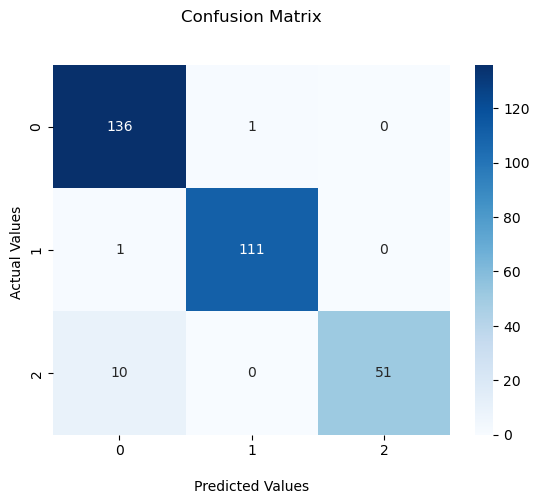

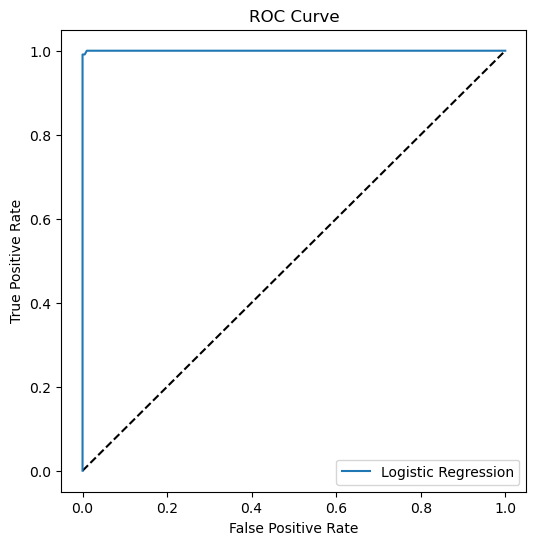

C:\Users\kulin\AppData\Local\Temp\ipykernel_16596\3037033196.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'F1_score train': f1_metric_train, 'AUC': auc_metric,'Accuracy': accuracy_metric, 'Precision': precision_metric,'Recall': recall_metric},


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       137
           1       1.00      0.99      1.00       112
           2       1.00      0.89      0.94        61

    accuracy                           0.97       310
   macro avg       0.98      0.96      0.97       310
weighted avg       0.98      0.97      0.97       310



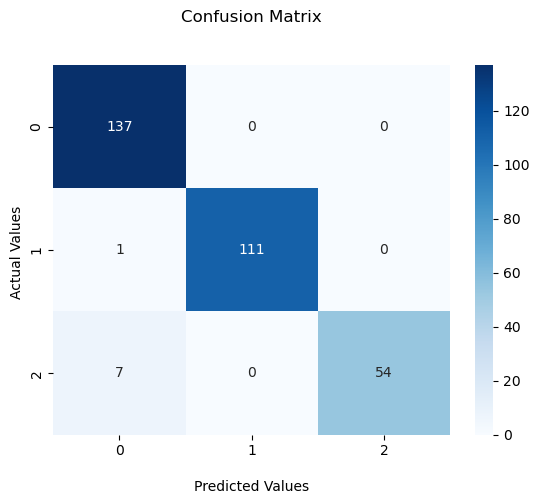

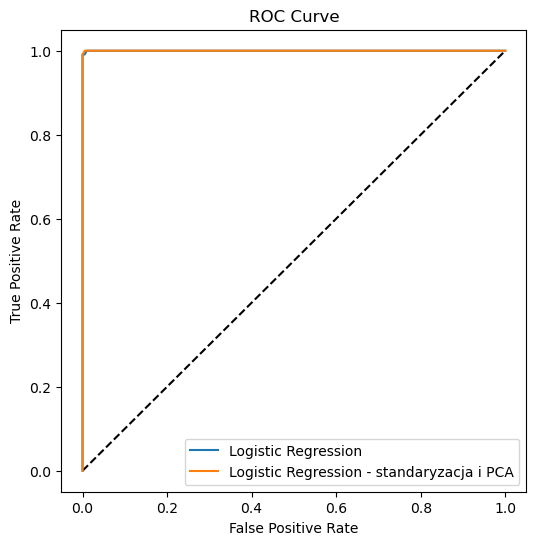

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       137
           1       1.00      0.99      1.00       112
           2       1.00      0.90      0.95        61

    accuracy                           0.98       310
   macro avg       0.98      0.96      0.97       310
weighted avg       0.98      0.98      0.98       310



C:\Users\kulin\AppData\Local\Temp\ipykernel_16596\3037033196.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'F1_score train': f1_metric_train, 'AUC': auc_metric,'Accuracy': accuracy_metric, 'Precision': precision_metric,'Recall': recall_metric},


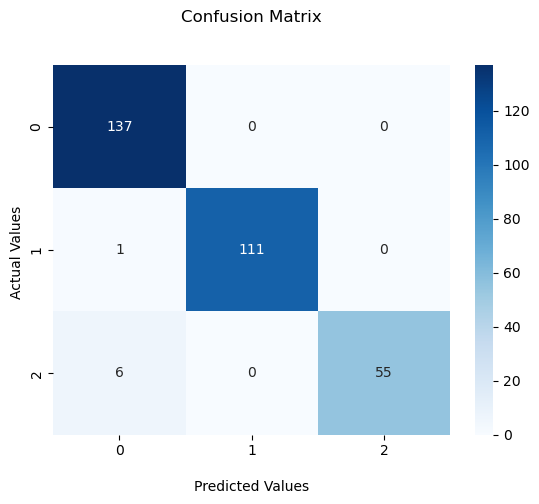

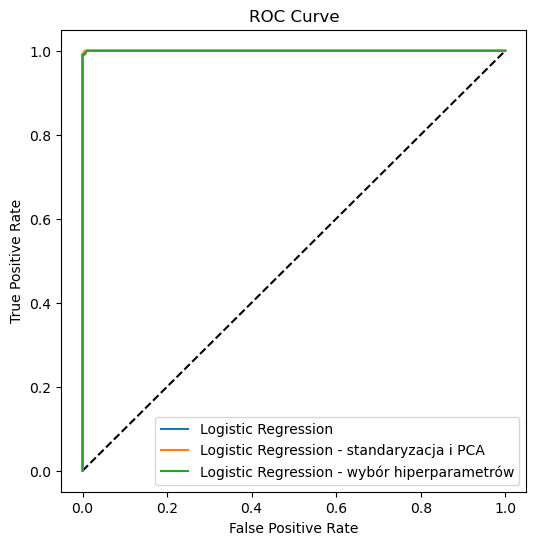

C:\Users\kulin\AppData\Local\Temp\ipykernel_16596\3037033196.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'F1_score train': f1_metric_train, 'AUC': auc_metric,'Accuracy': accuracy_metric, 'Precision': precision_metric,'Recall': recall_metric},


,Model,F1_score,F1_score train,AUC,Accuracy,Precision,Recall
0,Logistic Regression,0.960532,1.0,0.998902,0.961290,0.963704,0.961290
1,Logistic Regression - standaryzacja i PCA,0.973865,1.0,0.998981,0.974194,0.975617,0.974194
2,Logistic Regression - wybór hiperparametrów,0.977193,1.0,0.996720,0.977419,0.978517,0.977419


In [30]:
calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)
calculate_metrics(model_pipeline_v2, 'Logistic Regression - standaryzacja i PCA', X_test, y_test)
calculate_metrics(model_v3, 'Logistic Regression - wybór hiperparametrów', X_test, y_test)